# Chapter 4 Exercises

In [2]:
import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt
import scipy.stats as stats

C:\Users\Mikko\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Mikko\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [5]:
az.style.use('arviz-darkgrid')

### 4E1

The likelihood is given by

$$ y_i \sim N(\mu, \sigma) $$

### 4E2

There are two parameters that are estimated: $ \mu $ and $ \sigma $

### 4E3

The form of Bayes' theorem appropriate for the model is:

$$ P(\mu, \sigma \mid y_i) = \frac{P(y_i \mid \sigma , \mu ) P(\mu,\sigma)}{P(y_i)}$$

Assuming that the parameters $ \mu, \sigma$ are i.i.d, and the observations of $ y_i $ are likewise i.i.d, we get the form:

$$ P(\mu, \sigma \mid y_i) = \frac{ \prod_i P(y_i) P(\mu) P(\sigma)}{\int \int \prod_i P(y_i) P(\mu) P(\sigma) d\mu d\sigma}$$

### 4E4

The linear model is

$$ \mu_i = \alpha + \beta x_i $$

### 4E5

There are 3 parameters estimated in the model: $ \alpha, \beta, \sigma$

### 4M1

$$ y_i \sim N(\mu, \sigma) $$
$$ \mu \sim N(0,10) $$
$$ \sigma \sim U(0,10) $$

Instead of quap, we sample using MCMC with pymc3

In [24]:
with pm.Model() as m41:
    mu = pm.Normal('mu', mu = 0, sd= 10)
    sigma = pm.Uniform('sigma', lower=0, upper = 10)
    y = pm.Normal('y', mu=mu, sd=sigma)
    trace_m41 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1483.24draws/s]
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6947354743196776, but should be close to 0.8. Try to increase the number of tuning steps.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


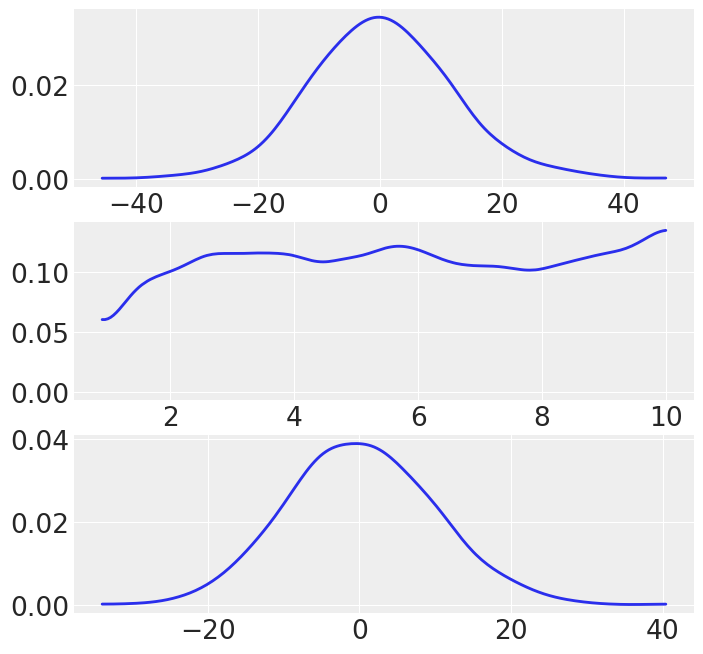

In [50]:
fig,ax = plt.subplots(3, figsize = (8,8))
az.plot_kde(trace_m41['y'], ax = ax[0])
az.plot_kde(trace_m41['sigma'], ax = ax[1])
az.plot_kde(trace_m41['mu'], ax = ax[2])

Compare with sampling manually:

In [26]:
sample_mu = stats.norm.rvs(0,10,1000)

In [27]:
sample_sigma = stats.uniform.rvs(0,10,1000)

In [28]:
sample_y = stats.norm.rvs(sample_mu,sample_sigma)

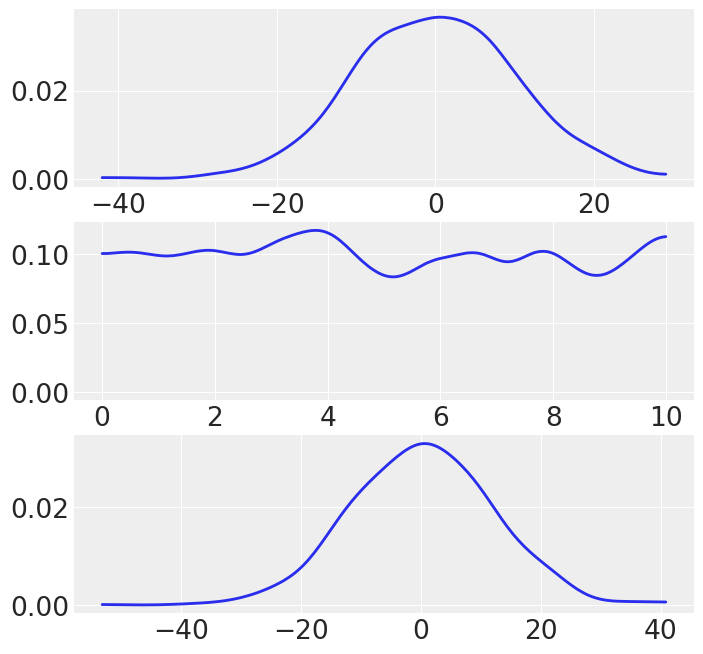

In [51]:
fig,ax = plt.subplots(3,figsize = (8,8))
az.plot_kde(sample_mu, ax = ax[0])
az.plot_kde(sample_sigma, ax = ax[1])
az.plot_kde(sample_y, ax = ax[2])

In [34]:
pm.stats.hpd(sample_y,0.11)

array([-18.00154287,  18.27252082])

In [35]:
pm.stats.hpd(trace_m41['y'],0.11)

array([-17.5069507 ,  18.77764553])

### 4M2

Model for heights:

$$ h_i \sim N( \mu_i, \sigma) $$
$$ \mu_i = \alpha + \beta * x_i $$
$$ \alpha = N(100,20) $$
$$ \beta = N(0,10) $$
$$ \sigma = U(0,50)$$

### 4M3

Average height is 120 cm $ \rightarrow $ change mean of $\alpha$ to 120

$ \beta $ is always positive $ \rightarrow $ change to lognormal distribution: $ \beta = logN(0,1) $